# Package

In [1]:
import argparse
import os
import sys
import time

# import matplotlib
# matplotlib.use('Agg')
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf

from func.data_generator import get_label_path, DataGenerator
from func.unet_model import NeuralNetwork
from func.plot import plt_learning_curve
from func.callbacks import MyCallbacks
from func.data_generator import my_aug
from func.metrics import mean_iou_score
from func.tool import get_fname


/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Model Built!


# Parser

In [2]:
parser = argparse.ArgumentParser()
parser.add_argument('--gpu', dest='gpu', default='0')
parser.add_argument('--test_mode', dest='test_mode', default= False , type=bool)

### data
parser.add_argument('--SAVEDIR', dest='SAVEDIR', default='model/Unet_rmbg') # 'Unet_5comps', #Unet_rmbg
parser.add_argument('--labeltype', dest='labeltype', default='.png') # '.npy'  '.png'
parser.add_argument('--num_class', dest='num_class', default= 1, type=int)
parser.add_argument('--XX_DIR', dest='XX_DIR', default='data/ori/tesri/')
parser.add_argument('--YY_DIR', dest='YY_DIR', default='model/Unsup_rmbg/result_sample/predict_mask_postprocessd/')

parser.add_argument('--image-h', dest='im_h', default=256, type=int)
parser.add_argument('--image-w', dest='im_w', default=256, type=int)
parser.add_argument('--image-c', dest='im_c', default=3, type=int)


### model
parser.add_argument('--epoch', dest='epoch', type=int, default=300)
parser.add_argument('--bz', '--batch-size', dest='bz', type=int, default=16)
parser.add_argument('--lr', '--learning-rate', dest='lr', type=float, default=1e-4)
parser.add_argument('--current_best_val_loss', dest='current_best_val_loss', default=float("inf"), type=float)
parser.add_argument('--earlystop_patience', dest='earlystop_patience', default=25, type=float)
parser.add_argument('--min_delta', dest='min_delta', default=0, type=float)
parser.add_argument('--lr_patience', dest='lr_patience', default= 10, type=int)
parser.add_argument('--lr_reduce_factor', dest='lr_reduce_factor', default= 0.5, type=float)
parser.add_argument('--keep_prob', dest='keep_prob', default= 1, type=float)
parser.add_argument('--log_step', dest='log_step', default= 0.2, type=float)
parser.add_argument('--momentum', dest='momentum', default= 0.9, type=float)

### return parser
args = parser.parse_args([])

### set GPU
os.environ["CUDA_VISIBLE_DEVICES"] = args.gpu

# Data & Generator

In [3]:
### DATA PREPARING
XX_DIR = args.XX_DIR
YY_DIR = args.YY_DIR
Xname = os.listdir(YY_DIR)
Xname = [get_fname(name) for name in Xname]

name_train, name_test = train_test_split(Xname,      test_size=2/10, random_state=55)
name_train, name_val  = train_test_split(name_train, test_size=3/10, random_state=55)

Xtrain = [os.path.join(XX_DIR, name+'.jpg') for name in name_train]
Xval   = [os.path.join(XX_DIR, name+'.jpg') for name in name_val]
Xtest  = [os.path.join(XX_DIR, name+'.jpg') for name in name_test]

if args.labeltype =='.npy':
    if args.num_class==1:
        task_type = 'mothmask'
    if args.num_class==5:
        task_type = 'multilabel'
    Ytrain = [get_label_path(i, YY_DIR, task_type = task_type) for i in Xtrain]
    Yval   = [get_label_path(i, YY_DIR, task_type = task_type) for i in Xval]
    Ytest  = [get_label_path(i, YY_DIR, task_type = task_type) for i in Xtest]
if args.labeltype =='.png':
    Ytrain = [os.path.join(YY_DIR, name+'.png') for name in name_train]
    Yval   = [os.path.join(YY_DIR, name+'.png') for name in name_val]
    Ytest  = [os.path.join(YY_DIR, name+'.png') for name in name_test]

print('train: %s, %s' % (len(Xtrain), len(Ytrain)))
print('valid: %s, %s' % (len(Xval),   len(Yval)))
print('test : %s, %s' % (len(Xtest),  len(Ytest)))

train: 14154, 14154
valid: 6066, 6066
test : 5055, 5055


In [4]:
### Generator
datagen = DataGenerator(input_shape=(args.im_h, args.im_w, args.im_c))
train_gen = datagen.gen_train_data(Xtrain, Ytrain, bz=args.bz, img_augmenter=1)
val_gen   = datagen.get_test_data(Xval, Yval, bz=args.bz, img_augmenter=1)

### Epoch & Iter
train_iter = int(np.ceil(len(Xtrain)/(args.bz))) 
val_iter   = int(np.ceil(len(Xval)/(args.bz))) 
if args.test_mode == True:
        train_iter, val_iter = 2, 2

# Model

In [5]:
md = NeuralNetwork(args = args) 
md.build_graph()
md.attach_saver()

(?, ?, ?, 1)
(?, ?, ?, 1)
Build UNet Graph: 10 layers, 1766785 trainable weights


# Train

In [6]:
### Save DIR
save_dir = '%s/' %(args.SAVEDIR)
if not os.path.exists(save_dir):
     os.makedirs(save_dir)
### Model naming
train_logtime = time.strftime("%y%m%d%H%M%S")
if args.test_mode == True:
    train_logtime = train_logtime+'_test'
model_dir = os.path.join(save_dir, train_logtime)

with tf.Session(graph=md.graph) as sess: 
    cb = MyCallbacks(args, model_dir, md, sess)
    l_rate = cb.get_current_lr()
    ### Variable initialization.
    sess.run(tf.global_variables_initializer())

    ### Parameters that should be stored.
    params = {}
    params['train_loss']=[]
    params['valid_loss']=[]
    params['train_score']=[]
    params['valid_score']=[]
    
    while(cb.get_current_earlystop_status() is not True):
        ### Train
        train_loss_collector = []
        stime = time.time()
        for train_batch_i in range(train_iter):
            print('\r[TRAINING]-----train-mini-Batch ({}/{})'.format(train_batch_i+1, train_iter), end='\r')
            x_batch, y_batch= next(train_gen)

            train_loss_batch, train_pred_batch, _, __ = sess.run([md.loss_tf,
                                                                  md.y_pred_tf, 
                                                                  md.train_step_tf, 
                                                                  md.extra_update_ops_tf], 
                                                                  feed_dict={md.x_data_tf: x_batch, 
                                                                             md.y_data_tf: y_batch[:,:,:,0:args.num_class], 
                                                                             md.keep_prob_tf: args.keep_prob, 
                                                                             md.learn_rate_tf: l_rate,
                                                                             md.training_tf: True})
            train_loss_collector = np.append(train_loss_collector, train_loss_batch)

        ### Valid
        valid_loss_collector = []
        for valid_batch_i in range(val_iter):
            print('\r[Validating]-----valid-mini-Batch ({}/{})'.format(valid_batch_i+1, val_iter), end='\r')
            x_valid_batch, y_valid_batch= next(val_gen)
            val_loss_batch, val_pred_batch = sess.run([md.loss_tf, 
                                                       md.y_pred_tf], 
                                                       feed_dict = {md.x_data_tf: x_valid_batch,
                                                                    md.y_data_tf: y_valid_batch[:,:,:,0:args.num_class], 
                                                                    md.keep_prob_tf: 1.0})
            valid_loss_collector = np.append(valid_loss_collector, val_loss_batch)
        ### training log
        train_loss = np.mean(train_loss_collector)
        valid_loss = np.mean(valid_loss_collector)
        params['train_loss'].extend([train_loss])
        params['valid_loss'].extend([valid_loss])
        
        
         ### callbacks
        epoch_counter = cb.update_record(train_loss = train_loss,
                                         valid_loss = valid_loss,
                                         l_rate=l_rate,
                                         save_ckpt = True,
                                         earlystop = True,
                                         reduce_lr = True,
                                         print_out = True)
        l_rate = cb.get_current_lr()

        if epoch_counter >= cb.get_epoch():
            break
print('Training Ended')
print('model_dir: ', model_dir)

Epoch[2/300] Pat[0/25] LR-Pat[0/10]---|train/valid-loss[0.0842/0.0402]|414.86 secs|l-rate:0.0001|
------------[Model saved!]: model/Unet_rmbg/181128103535/model_ckpt	
Epoch[3/300] Pat[0/25] LR-Pat[0/10]---|train/valid-loss[0.0341/0.0318]|402.97 secs|l-rate:0.0001|
------------[Model saved!]: model/Unet_rmbg/181128103535/model_ckpt	
Epoch[4/300] Pat[0/25] LR-Pat[0/10]---|train/valid-loss[0.0309/0.0257]|407.14 secs|l-rate:0.0001|
------------[Model saved!]: model/Unet_rmbg/181128103535/model_ckpt	
Epoch[5/300] Pat[0/25] LR-Pat[0/10]---|train/valid-loss[0.0266/0.0264]|406.15 secs|l-rate:0.0001|
Epoch[6/300] Pat[1/25] LR-Pat[1/10]---|train/valid-loss[0.0255/0.0243]|417.99 secs|l-rate:0.0001|
------------[Model saved!]: model/Unet_rmbg/181128103535/model_ckpt	
Epoch[7/300] Pat[0/25] LR-Pat[0/10]---|train/valid-loss[0.0238/0.0219]|382.0 secs|l-rate:0.0001|
------------[Model saved!]: model/Unet_rmbg/181128103535/model_ckpt	
Epoch[8/300] Pat[0/25] LR-Pat[0/10]---|train/valid-loss[0.0240/0.022

Epoch[70/300] Pat[5/25] LR-Pat[5/10]---|train/valid-loss[0.0132/0.0138]|383.25 secs|l-rate:5e-05|
Epoch[71/300] Pat[6/25] LR-Pat[6/10]---|train/valid-loss[0.0127/0.0135]|384.21 secs|l-rate:5e-05|
Epoch[72/300] Pat[7/25] LR-Pat[7/10]---|train/valid-loss[0.0130/0.0128]|382.45 secs|l-rate:5e-05|
Epoch[73/300] Pat[8/25] LR-Pat[8/10]---|train/valid-loss[0.0124/0.0131]|402.12 secs|l-rate:5e-05|
Epoch[74/300] Pat[9/25] LR-Pat[9/10]---|train/valid-loss[0.0127/0.0128]|409.51 secs|l-rate:5e-05|
------------[REDUCE Learning Rate]: to 2.5e-05 	
Epoch[75/300] Pat[10/25] LR-Pat[0/10]---|train/valid-loss[0.0123/0.0133]|415.22 secs|l-rate:2.5e-05|
Epoch[76/300] Pat[11/25] LR-Pat[1/10]---|train/valid-loss[0.0123/0.0122]|410.8 secs|l-rate:2.5e-05|
------------[Model saved!]: model/Unet_rmbg/181128103535/model_ckpt	
Epoch[77/300] Pat[0/25] LR-Pat[0/10]---|train/valid-loss[0.0122/0.0124]|410.72 secs|l-rate:2.5e-05|
Epoch[78/300] Pat[1/25] LR-Pat[1/10]---|train/valid-loss[0.0122/0.0129]|414.66 secs|l-rate:

model_dir:  model/Unet_rmbg/181128103535


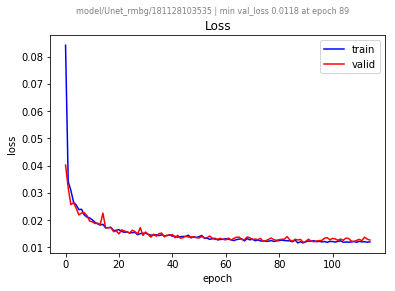

In [7]:
### learning curve
best_val_loss = min(params['valid_loss'])
best_epoch = np.argmin(params['valid_loss'])
                    
sub = 'min val_loss %.4f at epoch %s' % (best_val_loss, best_epoch)

fig = plt_learning_curve(params['train_loss'], params['valid_loss'],
                         title = 'Loss', sub = '%s | %s' %(model_dir, sub))
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
fig.savefig(os.path.join(model_dir, 'loss.png'))
print('model_dir: ', model_dir)
fig


# Test

In [8]:
### Generator & training setting 
datagen = DataGenerator(input_shape=(args.im_h, args.im_w, args.im_c))
test_gen  = datagen.get_test_data(Xtest, Ytest, bz=args.bz)
test_iter  = int(np.ceil(len(Xtest)/(args.bz))) 
epoch = args.epoch
if args.test_mode == True:
        test_iter = 2
        epoch = 10

In [9]:
# ### Test on previous model
# model_dir = 'model/Unet_rmbg/181121113804'

### Test on current model
checkpoint_path = os.path.join(model_dir, 'model_ckpt') 

with tf.Session(graph=md.graph) as sess: 
    sess.run(tf.global_variables_initializer()) # Variable initialization.
    meta_to_restore = checkpoint_path+'.meta'
    saver = tf.train.import_meta_graph(meta_to_restore)
    saver.restore(sess,checkpoint_path)
    print('Model Restored')
    
    test_loss_collector = []
    overall_miou = 0
    for test_batch_i in range(test_iter):
        print('\r[Testing]-----test-mini-Batch ({}/{})'.format(test_batch_i+1, test_iter), end='\r')
        #x_test_batch, y_test_batch, path = next(test_gen)
        x_test_batch, y_test_batch = next(test_gen)
        test_loss_batch, test_pred_batch = sess.run([md.loss_tf,md.y_pred_tf], 
                                                feed_dict = {md.x_data_tf: x_test_batch, 
                                                             md.y_data_tf: y_test_batch[:,:,:,0:args.num_class], 
                                                             md.keep_prob_tf: 1.0})

        test_loss_collector = np.append(test_loss_collector, test_loss_batch)
### mIoU        
        for idx in range(args.bz):
            ### making background channel
            plain = np.ones((256, 256))
            for i in range(args.num_class):       
                true_y = y_test_batch[idx]
                plain = plain-true_y[:,:,i]
            plain = np.where(plain>0.5, 1, 0)
            plain = np.expand_dims(plain, axis=2)
            true_y = np.concatenate((true_y,plain), axis = 2)
            
            ### making background channel
            plain = np.ones((256, 256))
            for i in range(args.num_class):
                pred_y = test_pred_batch[idx]
                plain = plain-pred_y[:,:,i]
            plain = np.where(plain>0.5, 1, 0)
            plain = np.expand_dims(plain, axis=2)
            pred_y = np.concatenate((pred_y,plain), axis = 2)

            true_y = np.argmax(true_y, axis=2)
            pred_y = np.argmax(pred_y, axis=2)
            print(mean_iou_score(pred_y, true_y, n_labels = args.num_class+1))
            
            overall_miou += mean_iou_score(pred_y, true_y, n_labels = args.num_class+1)  
    mIoU = overall_miou/(test_iter * args.bz)
    print('overall_miou on BRCAS:', mIoU) 
######################################### 
        
    test_loss = np.mean(test_loss_collector)
    print('\ntest loss: %.4f' % test_loss)

INFO:tensorflow:Restoring parameters from model/Unet_rmbg/181128103535/model_ckpt
Model Restored
0.9787532278089477-mini-Batch (1/316)
0.9883186416969829
0.9921995576230547
0.9913841316400342
0.9821274364590797
0.9740161980948401
0.9935054694168455
0.9801267426028462
0.9911433269808892
0.9853436354842755
0.9820504903765808
0.9636725288000518
0.9730542539304761
0.986017661279261
0.9868334807927626
0.9910211821768281
0.9892994968656335-mini-Batch (2/316)
0.9808765463509872
0.9895162133601769
0.9899425903992833
0.9601877392710848
0.9897085211500869
0.9932262699424178
0.9872350268100063
0.9914246949173675
0.9723404020715221
0.9905857088966208
0.9721198140812493
0.9847360662802265
0.9734521113235434
0.9849449274118061
0.9886045707376621
0.9877643321611962-mini-Batch (3/316)
0.9824468798602399
0.9869954819443232
0.9891559219645917
0.9901799742085454
0.9915560643895522
0.9891597751798502
0.9785900887386823
0.9898152528249916
0.990375401781749
0.985403818416977
0.9816162476920467
0.98632269111

0.9935601589360012-mini-Batch (27/316)
0.9880258368758872
0.9813963735948303
0.9890975973864264
0.9895830320569503
0.9877873632460885
0.9856510901748686
0.9824026425582837
0.979345338467224
0.9844457181339357
0.9895646314848021
0.9824251782572276
0.9899890782658582
0.9899037528869106
0.9869795731142975
0.9803973967229922
0.989904024642319t-mini-Batch (28/316)
0.9917317499753591
0.9916858208772745
0.9906649127755061
0.985283266832127
0.9864676189509638
0.9914206564286726
0.991486374830619
0.9868846312194473
0.9798091552441053
0.9908485394808559
0.9858778062699602
0.9910381814647808
0.9871920627857588
0.9909232523458146
0.9845484990989588
0.9911799511355681-mini-Batch (29/316)
0.9832176697405495
0.9905298758824719
0.9855316357674981
0.9760023712241556
0.9883956165771286
0.9928003349013423
0.9891346057834856
0.9917656928079424
0.9861620217936733
0.9920694182041021
0.9838654315454064
0.9880513281715184
0.9888172164083977
0.9849707924213613
0.9799758052308745
0.9885130008701755-mini-Batch (

0.9913561297047373-mini-Batch (53/316)
0.9907532515286297
0.9858427960542874
0.9845012310791623
0.9905359997629635
0.9884905866543547
0.9882033557116476
0.9895418124056663
0.9885408423194845
0.9940232864782552
0.9829221270539701
0.9900623076917716
0.9875958775407349
0.9885198934561432
0.9896064086584979
0.9882279644134673
0.9723095955467538-mini-Batch (54/316)
0.9605237027473313
0.9903823126674632
0.9492996865354436
0.9829222527275139
0.9771304841447639
0.9821638725933182
0.9884109338293793
0.9843833478142886
0.9867582988161998
0.9894112243269394
0.9823060527708389
0.9912419088582803
0.9912352825471673
0.9765786776981664
0.9875310863393532
0.9840468598940912-mini-Batch (55/316)
0.983023847730875
0.9863028146568147
0.9895482703871081
0.9917105621200002
0.98803256156657
0.9840688359481486
0.9919497295981893
0.9835670231131415
0.9866742643348028
0.9882225799510087
0.9900093967439992
0.9826294600797898
0.9891966305565215
0.9849890543765982
0.9872776474123754
0.9871378292770597-mini-Batch (

0.9622814156746615-mini-Batch (79/316)
0.9885650282511933
0.9852409069824779
0.9807248536617739
0.9703383170086712
0.9892050382240526
0.9847415776398835
0.9752189209022722
0.979477960156435
0.980254424673068
0.9841497695075812
0.9907354329121796
0.9937994616277114
0.984213755576743
0.9847795380094029
0.9863370101585396
0.9678922739515674-mini-Batch (80/316)
0.9894550373009743
0.989857656899473
0.9821688850856969
0.9788040706627003
0.988198610539265
0.9886945713091841
0.973676744244942
0.9869002062036021
0.989907224546334
0.9885565545665469
0.9840855630881506
0.9805319096883114
0.9860938951290561
0.9911775144693786
0.9814414484705885
0.9850753104520009-mini-Batch (81/316)
0.9840040389803306
0.9810881832392956
0.9873943766213439
0.9700506433203908
0.986328208971459
0.9884261391733148
0.9847382398040975
0.9908070365891704
0.9864843397256748
0.9798396624574613
0.9848110502533856
0.9876675546661161
0.9607500810206258
0.986365257249286
0.9930065470074808
0.9885266481839233-mini-Batch (82/316

0.9891492513246753-mini-Batch (105/316)
0.9787555648242543
0.978499015246012
0.9819513364410657
0.9802509437518518
0.9889045422891172
0.9798001869352271
0.966354527260187
0.9905510746423465
0.9871023786465489
0.9850470814803738
0.9832038743268169
0.9922550176748789
0.9856505139450726
0.9912236484150827
0.9912560537503257
0.9893553612050032-mini-Batch (106/316)
0.9876636080602099
0.9915571472842011
0.9814977747483995
0.9842449440065253
0.9844463091008064
0.9934579634053123
0.9861379755114836
0.982067092177803
0.9918388088940862
0.982948489311037
0.9712656058015862
0.985951289843346
0.9902229967912908
0.9845521225665965
0.9852593618986247
0.9762414758584346-mini-Batch (107/316)
0.9883378048209301
0.9903604240325482
0.9883235915239164
0.9819187507110616
0.9770520275237665
0.9928519001456341
0.988869499438483
0.9852286445197274
0.9883105282021571
0.9934506780789036
0.9841107247154177
0.9828683264617297
0.9811641285171647
0.9856322429191531
0.9831884520824613
0.9914096139998411-mini-Batch (

0.9659559728091995-mini-Batch (131/316)
0.9874088654269647
0.9907122750057867
0.98395320349509
0.9839086374993107
0.9793442462500488
0.9783846340512773
0.9910823910603279
0.9934539936761522
0.9839447170517178
0.9918471244346354
0.9893813351985512
0.9783534045627849
0.9859225407818398
0.9893947983693682
0.9886622701196297
0.9838312134063744-mini-Batch (132/316)
0.9904119562918815
0.9897307478846117
0.9896988886663997
0.9810528165574357
0.9901713538220782
0.9621911979211497
0.9866761816583123
0.9903728775786479
0.9914443764239171
0.9919856589927092
0.9757358328508188
0.9876941694699906
0.9812352351348759
0.9914729732777605
0.990206328262079
0.9834361192851317-mini-Batch (133/316)
0.9820716199618587
0.9881344419855331
0.9853494460936669
0.9901803028020524
0.9843045397684014
0.9911427018856143
0.9811559027043433
0.9682576151420864
0.9882154709744215
0.9849035792251486
0.9823912276851758
0.9823658325962819
0.9882608476555121
0.9920283638856066
0.9870013470266463
0.9746471108203171-mini-Batc

0.9876972733496505-mini-Batch (157/316)
0.9872664911996843
0.9575402273193863
0.9909212807085808
0.9900984348905406
0.968318845638933
0.9904237412386268
0.9885907035744421
0.9900221300071753
0.9855108088641219
0.9871817481008983
0.9863310131733238
0.9847629357197674
0.9606752759645081
0.9912559245096537
0.9849827523923054
0.9873423302920217-mini-Batch (158/316)
0.9699470453222829
0.9807548508773716
0.9718451692377881
0.98950346089102
0.9918754122201096
0.9892929313223948
0.9760277730909104
0.9906177222640081
0.9597298894478454
0.9889126457782211
0.9832833099061831
0.9912143945873262
0.9857381201249245
0.9880723541945817
0.9892494605372759
0.9825064343855308-mini-Batch (159/316)
0.9713601232104219
0.9895544456475898
0.9886044733380791
0.9874220660597967
0.9694890559610361
0.98128711132435
0.9863966553911423
0.9870919937382532
0.9918472051386795
0.9712910939976687
0.9902891870635664
0.9881760810346671
0.9885094877884812
0.9872555247658847
0.9809939067444853
0.9933055658452854-mini-Batch 

0.9919990590528606-mini-Batch (183/316)
0.9928682527726989
0.9890092382196541
0.9800165116084355
0.9793742651802406
0.9829350599318596
0.9893429831167688
0.9910528833008769
0.9842414955150638
0.9882105051571126
0.9923363468798972
0.9902249869887474
0.9915327002029901
0.9866023195889991
0.9842633780000922
0.9926036939589948
0.9801106853312442-mini-Batch (184/316)
0.9800062955416331
0.9900723876361921
0.976672252825443
0.9885039396223512
0.9793962287742911
0.9817162752351725
0.9919866882468945
0.98583129902804
0.977354830753673
0.97665272520698
0.9920709646337815
0.9659643610024753
0.9823180538114845
0.9895189449040553
0.9859789834952573
0.9851274049209287-mini-Batch (185/316)
0.9880204287361827
0.9896555256215649
0.9833001082845858
0.9868011582494411
0.99321863265512
0.9816495329885768
0.9897989449069213
0.9895458894042741
0.9889703826924819
0.9909633779976788
0.990448756740841
0.9890881958270458
0.9855019432933105
0.9811025143518344
0.9864364659408662
0.9785565663523081-mini-Batch (186

0.9833920412635697-mini-Batch (209/316)
0.9934775095207464
0.9851097883464384
0.9872757973993219
0.986419299840925
0.991711224723454
0.9813932591076302
0.9780749783062087
0.9852061996747992
0.9791355763011281
0.9842091406650894
0.9918799041152837
0.9885278693242305
0.9817288748771325
0.9851295234047568
0.9935654437419109
0.9893545222650149-mini-Batch (210/316)
0.9864169959934569
0.9888285340202914
0.9802978543814085
0.9902082616569825
0.9863138640167026
0.9844521412418075
0.9859497634021319
0.9934163306444468
0.990441834913415
0.9807205324070147
0.9888925570044224
0.9779564972785526
0.9875350995500001
0.9845283143184982
0.9907726772762514
0.9877412289344083-mini-Batch (211/316)
0.9861264067911397
0.9846408380726448
0.9916863466482266
0.9885213941777821
0.9870205474036149
0.9858884377504609
0.9785530690949424
0.9875821364990884
0.9815669937916929
0.9930119305719387
0.9924625395227387
0.9706969472722796
0.9886870774203504
0.9907893364773757
0.9883364664414762
0.9911154702259917-mini-Batc

0.9918614765346199-mini-Batch (235/316)
0.9858251193034973
0.9899225175919695
0.9858349682371891
0.9924413314106523
0.9802063874659486
0.9896294865200642
0.9876813209172273
0.9706434650906716
0.9771724655124353
0.9872168475781247
0.9694302960223862
0.9854172666886638
0.974469912577719
0.9908219173615181
0.9863935485759392
0.9873834051009432-mini-Batch (236/316)
0.9637624788756043
0.994047416643972
0.9769017535920264
0.9854162882685444
0.9884295192974326
0.9843679791916199
0.9872122367870864
0.9754038402226647
0.9715791390065771
0.9884415333099874
0.9745028391580312
0.9799996110453317
0.9815102017636796
0.9890869430738484
0.9803540837187936
0.9871543630783708-mini-Batch (237/316)
0.9794086137557492
0.9872035376662948
0.9895644021277537
0.9685984166048439
0.9764219913939773
0.9600273264056896
0.9793567063033066
0.9705427588169726
0.9770568621411493
0.9835394814785299
0.9696018447413406
0.987557406292351
0.9917965805442797
0.9912998047356707
0.9859814271154621
0.9877405492132525-mini-Batc

0.9833075986986672-mini-Batch (261/316)
0.9756033607839103
0.9869904765799202
0.988042294908928
0.9898995796787635
0.9789509830293264
0.978274799540849
0.9895877214678588
0.9873005211824413
0.991154421373645
0.9794843031630076
0.9851338873572741
0.9873339882625336
0.9917157933003997
0.9895627447156798
0.9821570759945459
0.9824412031924503-mini-Batch (262/316)
0.9561537998370362
0.9654886655445192
0.9845747766784746
0.9870868952597328
0.982894036267757
0.9911019521545308
0.9836687085021203
0.9889428871360266
0.9886936230863106
0.9884035375156353
0.9854849796194787
0.9928724975299902
0.9779617861186094
0.975410546392582
0.9839494429280455
0.939389494530477t-mini-Batch (263/316)
0.9911461086244453
0.9920026106265899
0.984439508080613
0.9858947282081894
0.9899478883988607
0.9911808801210047
0.9846393899922797
0.9920469235865153
0.9891821009506372
0.9874821505305356
0.9928437774313533
0.9918483573593411
0.9856285113374738
0.98482451228043
0.9846853792212977
0.9780826472648056-mini-Batch (26

0.9916246947484801-mini-Batch (287/316)
0.9902012509716943
0.9862677125411314
0.9831345000827754
0.9750813972001985
0.9860508574125737
0.9929298892549334
0.989064771061315
0.9762398868907924
0.9911156963657446
0.9869213896041256
0.9863400649180316
0.9778330654250555
0.9837912107546463
0.9880916247423746
0.9791379956882694
0.981549574976495t-mini-Batch (288/316)
0.9800483066224223
0.9911819044200343
0.9816360861396991
0.9692522813626089
0.9862024529706053
0.9813678623082838
0.9908488675233436
0.9890262247151398
0.9843462496053113
0.9857184661678378
0.9699800748701848
0.9854675733930165
0.9881946057373765
0.9801320385414432
0.9891034602148261
0.9918502505911568-mini-Batch (289/316)
0.9915130451898109
0.9815742572905133
0.9816116749195447
0.9860923469529956
0.9862348184754302
0.9904138219967924
0.9779181158652004
0.9783676723813723
0.9922209194866201
0.9824332205393911
0.9809345539172354
0.9806050131202031
0.9771370889177288
0.9823617677669776
0.9414852580180628
0.9803858126582312-mini-Ba

0.9881847150352987-mini-Batch (313/316)
0.9885268534832015
0.9800290414606592
0.9862165937881826
0.9889929707946079
0.9866393304947598
0.9890492095935599
0.9895170520826185
0.9898641652153255
0.9717600980329562
0.9673079568455598
0.9818687273032549
0.9581249778009383
0.9890380680092014
0.9886322270761406
0.9819912088158236
0.9764728734843051-mini-Batch (314/316)
0.9879233216969545
0.9763789082569513
0.9791078763219145
0.9873022540608251
0.9892180280958123
0.9801069233104434
0.9900075548054083
0.986327456387621
0.9840871809853292
0.9875615043982935
0.9844728654201569
0.9849092997592382
0.986927152592474
0.9924392611206114
0.9857134159814513
0.9696090413763947-mini-Batch (315/316)
0.9817769981488935
0.9860151023759053
0.9811650532266778
0.9860405090512585
0.9802299966532837
0.9933942217147191
0.9926426025035722
0.9841733893306126
0.987950115202214
0.9914321048880813
0.9904761483858807
0.9694969603059036
0.9833511824423591
0.9840657498957242
0.9806054780643809
0.9918428791220748-mini-Batc

# SAVE_LOG

In [10]:
### Save log
summary_save = '%s/training_summary.csv' %(args.SAVEDIR)
# save into dictionary
sav = vars(args)
sav['test_loss'] = test_loss 
sav['mIoU'] = mIoU
sav['model_dir'] = model_dir
sav['best_val_loss'] =  best_val_loss
sav['best_epoch'] = best_epoch

### Append into summary files
dnew = pd.DataFrame(sav, index=[0])
if os.path.exists(summary_save):
    dori = pd.read_csv(summary_save)
    dori = pd.concat([dori, dnew])
    dori.to_csv(summary_save, index=False)
else:
    dnew.to_csv(summary_save, index=False)

print(summary_save)

model/Unet_rmbg/training_summary.csv


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:15: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  from ipykernel import kernelapp as app
